# ShuffleNet 模型关键创新点总结

## 1. 核心创新操作
- **Pointwise Group Convolution（分组逐点卷积）**  
  通过将逐点卷积（1x1卷积）操作分组处理，显著降低计算量，同时保持特征表达能力。

- **Channel Shuffle（通道混洗）**  
  在分组卷积后引入通道混洗操作，增强不同组之间的信息交互，避免因分组导致的特征表达能力下降。


<img src="resources/shufflenet_v1_illustration.png" alt="drawing" width="50%"/>

## 2. 轻量化设计思路
- **结合深度可分离卷积（Depthwise Separable Convolution）**  
  在瓶颈层（bottleneck layer）中融合深度可分离卷积，进一步减少计算成本，适用于移动端低算力场景。

<img src="resources/shufflenet_v1_block.png" alt="drawing" width="75%"/>


In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Device: ", DEVICE)

Device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.auto_augmentation import ImageNetPolicy

from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

In [3]:
import torchsummary
from hdd.models.cnn.shufflenetv1 import ShuffleNetV1

net = ShuffleNetV1(
    num_classes=10,
    group=8,
    width_multiplier=1,
    dropout=0.5,
).to(DEVICE)
torchsummary.summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
           _Conv2d-4         [-1, 24, 112, 112]               0
         MaxPool2d-5           [-1, 24, 56, 56]               0
            Conv2d-6          [-1, 192, 28, 28]          41,472
       BatchNorm2d-7          [-1, 192, 28, 28]             384
           _Conv2d-8          [-1, 192, 28, 28]               0
            Conv2d-9           [-1, 96, 56, 56]             288
      BatchNorm2d-10           [-1, 96, 56, 56]             192
             ReLU-11           [-1, 96, 56, 56]               0
          _Conv2d-12           [-1, 96, 56, 56]               0
        Rearrange-13           [-1, 96, 56, 56]               0
           Conv2d-14           [-1, 96,

In [4]:
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    train_dataloader,
    val_dataloader,
    net,
    lr=1e-3,
    weight_decay=0,
    max_epochs=200,
) -> dict[str, list[float]]:

    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return training_stats


train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)

net = ShuffleNetV1(
    num_classes=10,
    group=8,
    width_multiplier=1,
    dropout=0,
).to(DEVICE)
width_multiplier_1 = train_net(
    train_dataloader,
    val_dataloader,
    net,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 7588450
Epoch: 1/200 Train Loss: 2.1347 Accuracy: 0.2534 Time: 12.15335  | Val Loss: 2.0681 Accuracy: 0.3572
Epoch: 2/200 Train Loss: 1.7995 Accuracy: 0.3952 Time: 12.21192  | Val Loss: 1.6747 Accuracy: 0.4504
Epoch: 3/200 Train Loss: 1.6586 Accuracy: 0.4452 Time: 12.18383  | Val Loss: 1.3061 Accuracy: 0.5674
Epoch: 4/200 Train Loss: 1.5468 Accuracy: 0.4893 Time: 12.22919  | Val Loss: 1.2447 Accuracy: 0.5888
Epoch: 5/200 Train Loss: 1.4453 Accuracy: 0.5208 Time: 12.22658  | Val Loss: 1.3383 Accuracy: 0.5946
Epoch: 6/200 Train Loss: 1.3842 Accuracy: 0.5383 Time: 12.23240  | Val Loss: 1.1009 Accuracy: 0.6538
Epoch: 7/200 Train Loss: 1.3151 Accuracy: 0.5735 Time: 12.17363  | Val Loss: 0.9334 Accuracy: 0.6994
Epoch: 8/200 Train Loss: 1.2862 Accuracy: 0.5819 Time: 12.17213  | Val Loss: 1.0573 Accuracy: 0.6690
Epoch: 9/200 Train Loss: 1.2413 Accuracy: 0.5947 Time: 12.30401  | Val Loss: 1.1632 Accuracy: 0.6548
Epoch: 10/200 Train Loss: 1.1554 Accuracy: 0.6198 Time: 12.24594  | Val

In [5]:
net = ShuffleNetV1(
    num_classes=10,
    group=8,
    width_multiplier=0.75,
    dropout=0,
).to(DEVICE)
width_multiplier_75 = train_net(
    train_dataloader,
    val_dataloader,
    net,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 4293130
Epoch: 1/200 Train Loss: 2.1145 Accuracy: 0.2523 Time: 8.33201  | Val Loss: 1.9252 Accuracy: 0.3511
Epoch: 2/200 Train Loss: 1.8263 Accuracy: 0.3801 Time: 8.35828  | Val Loss: 1.4548 Accuracy: 0.5144
Epoch: 3/200 Train Loss: 1.6380 Accuracy: 0.4440 Time: 8.33114  | Val Loss: 1.3983 Accuracy: 0.5508
Epoch: 4/200 Train Loss: 1.5333 Accuracy: 0.4892 Time: 8.30735  | Val Loss: 1.3167 Accuracy: 0.5819
Epoch: 5/200 Train Loss: 1.4559 Accuracy: 0.5134 Time: 8.33318  | Val Loss: 1.3632 Accuracy: 0.5595
Epoch: 6/200 Train Loss: 1.4018 Accuracy: 0.5355 Time: 8.39578  | Val Loss: 1.0578 Accuracy: 0.6558
Epoch: 7/200 Train Loss: 1.3543 Accuracy: 0.5520 Time: 8.34919  | Val Loss: 0.9298 Accuracy: 0.7001
Epoch: 8/200 Train Loss: 1.2640 Accuracy: 0.5836 Time: 8.40338  | Val Loss: 1.0247 Accuracy: 0.6818
Epoch: 9/200 Train Loss: 1.2254 Accuracy: 0.5953 Time: 8.46951  | Val Loss: 0.9249 Accuracy: 0.7032
Epoch: 10/200 Train Loss: 1.1865 Accuracy: 0.6125 Time: 8.37430  | Val Loss: 0.7

In [6]:
net = ShuffleNetV1(
    num_classes=10,
    group=8,
    width_multiplier=0.5,
    dropout=0,
).to(DEVICE)
width_multiplier_50 = train_net(
    train_dataloader,
    val_dataloader,
    net,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 1930066
Epoch: 1/200 Train Loss: 2.1060 Accuracy: 0.2468 Time: 6.72420  | Val Loss: 1.8938 Accuracy: 0.3381
Epoch: 2/200 Train Loss: 1.8103 Accuracy: 0.3798 Time: 6.76190  | Val Loss: 1.5079 Accuracy: 0.4910
Epoch: 3/200 Train Loss: 1.6800 Accuracy: 0.4349 Time: 6.70241  | Val Loss: 1.3193 Accuracy: 0.5529
Epoch: 4/200 Train Loss: 1.5755 Accuracy: 0.4657 Time: 6.70783  | Val Loss: 1.3660 Accuracy: 0.5567
Epoch: 5/200 Train Loss: 1.4889 Accuracy: 0.5087 Time: 6.70230  | Val Loss: 1.2464 Accuracy: 0.5776
Epoch: 6/200 Train Loss: 1.4356 Accuracy: 0.5276 Time: 6.70042  | Val Loss: 1.1289 Accuracy: 0.6339
Epoch: 7/200 Train Loss: 1.3768 Accuracy: 0.5447 Time: 6.75012  | Val Loss: 1.2432 Accuracy: 0.5985
Epoch: 8/200 Train Loss: 1.3111 Accuracy: 0.5605 Time: 6.80263  | Val Loss: 0.9809 Accuracy: 0.6813
Epoch: 9/200 Train Loss: 1.2651 Accuracy: 0.5769 Time: 6.79302  | Val Loss: 0.9494 Accuracy: 0.6922
Epoch: 10/200 Train Loss: 1.2388 Accuracy: 0.5933 Time: 6.87276  | Val Loss: 1.0

In [7]:
net = ShuffleNetV1(
    num_classes=10,
    group=8,
    width_multiplier=0.25,
    dropout=0,
).to(DEVICE)
width_multiplier_25 = train_net(
    train_dataloader,
    val_dataloader,
    net,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 499258
Epoch: 1/200 Train Loss: 2.1346 Accuracy: 0.2261 Time: 5.52261  | Val Loss: 1.8464 Accuracy: 0.3213
Epoch: 2/200 Train Loss: 1.8443 Accuracy: 0.3662 Time: 5.62801  | Val Loss: 1.5167 Accuracy: 0.4841
Epoch: 3/200 Train Loss: 1.6846 Accuracy: 0.4339 Time: 5.45363  | Val Loss: 1.3995 Accuracy: 0.5312
Epoch: 4/200 Train Loss: 1.6050 Accuracy: 0.4549 Time: 5.61594  | Val Loss: 1.2271 Accuracy: 0.5926
Epoch: 5/200 Train Loss: 1.5383 Accuracy: 0.4814 Time: 5.50787  | Val Loss: 1.2427 Accuracy: 0.5832
Epoch: 6/200 Train Loss: 1.4665 Accuracy: 0.5117 Time: 5.53641  | Val Loss: 1.2087 Accuracy: 0.5967
Epoch: 7/200 Train Loss: 1.4198 Accuracy: 0.5243 Time: 5.53885  | Val Loss: 1.0875 Accuracy: 0.6423
Epoch: 8/200 Train Loss: 1.3901 Accuracy: 0.5342 Time: 5.61542  | Val Loss: 1.1810 Accuracy: 0.6173
Epoch: 9/200 Train Loss: 1.3628 Accuracy: 0.5496 Time: 5.59278  | Val Loss: 0.9550 Accuracy: 0.6915
Epoch: 10/200 Train Loss: 1.3108 Accuracy: 0.5720 Time: 5.44258  | Val Loss: 1.04

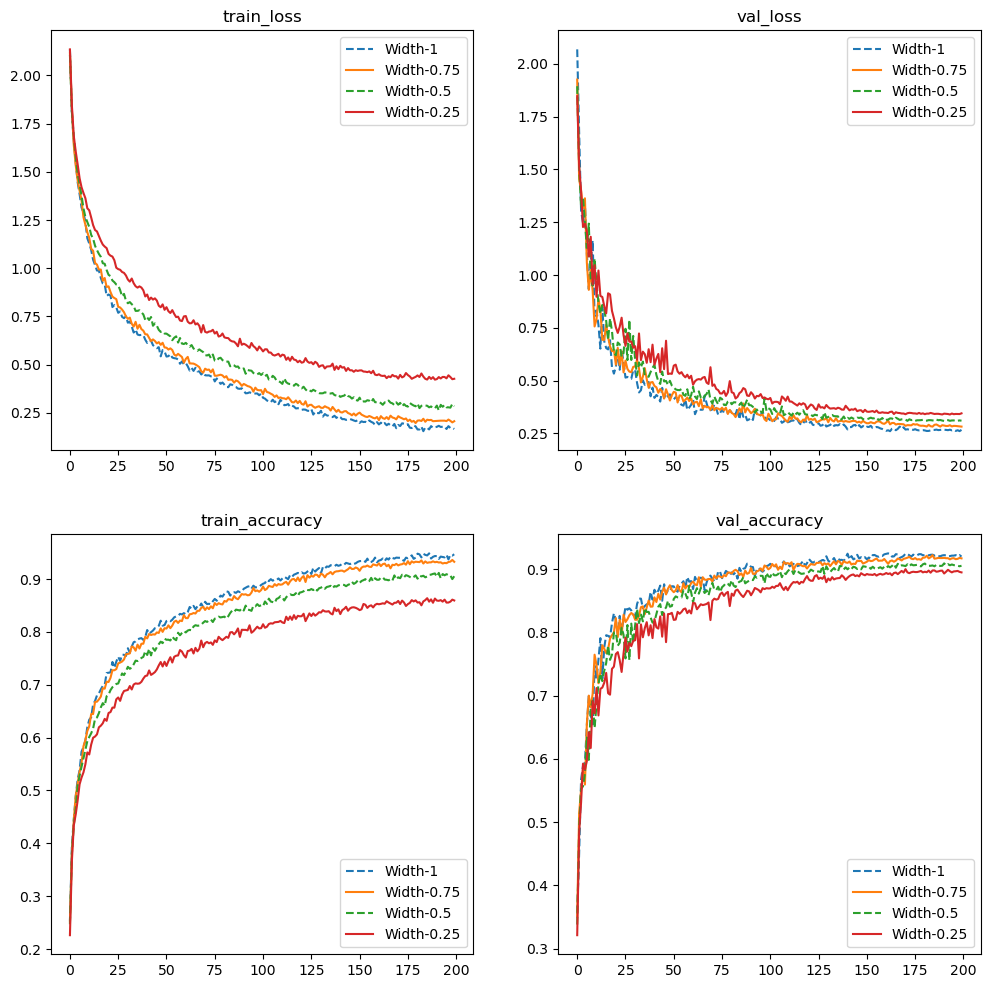

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = width_multiplier_1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(width_multiplier_1[field], label="Width-1", linestyle="--")
    plt.plot(width_multiplier_75[field], label="Width-0.75")
    plt.plot(width_multiplier_50[field], label="Width-0.5", linestyle="--")
    plt.plot(width_multiplier_25[field], label="Width-0.25", linestyle="-")
    plt.legend()
    plt.title(field)